In [52]:
import os
import keras
import tensorflow as tf
import numpy as np
import copy

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


In [66]:
import gait
from PIL import Image
from tensorflow.keras.utils import plot_model
from train import CVAE_FULL
from tqdm import tqdm
import cv2
from train_birnn import model_BiRNN, ImageNoise
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import gc
import pickle

PCA

In [4]:
EXP_NO = '044'
ANGLE_NO = '090'
gait_key_poses = 16
image_vec_shape = 12
conditional_vec_shape = 4
full_vec_shape = image_vec_shape+conditional_vec_shape
labels = ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']

In [3]:
labels = ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
batch_imgs = [None for _ in labels]
pro_imgs = [None for _ in labels]
names = [None for _ in labels]
for i, label in enumerate(labels):
    batch_imgs[i] = []
    names[i] = []
    for file in os.listdir('/'.join([
                                os.getcwd(),
                                'GaitDatasetB-silh',
                                EXP_NO,
                                label,
                                ANGLE_NO
                                ])):
        if file[-3:]!='png':
            continue
        
        batch_imgs[i].append(
                    gait.preprocess(
                        cv2.imread('/'.join([
                                            os.getcwd(),
                                            'GaitDatasetB-silh',
                                            EXP_NO,
                                            label,
                                            ANGLE_NO,
                                            file
                                        ])
                                   )
                                )
                            )
        names[i].append(
            '/'.join([
                     os.getcwd(),
                     'GaitDatasetB-silh',
                     EXP_NO,
                     label,
                     ANGLE_NO,
                     file
                     ])
        )
    batch_imgs[i] = np.array(batch_imgs[i])
    names[i] = np.array(names[i])
        

In [4]:
y = []
for i in range(len(labels)):
    y.append(i*np.ones((batch_imgs[i].shape[0])))
mainImgs = np.concatenate(batch_imgs,axis=0)
y = np.concatenate(y, axis=0)

In [5]:
mainImgs.shape

(377, 160, 120)

In [6]:
X, _, _, _, _, info = gait.get_feature_vectors(mainImgs,preproc=lambda x:x)

In [7]:
np.savez_compressed('eig90',**info)

# DataSet Generation

In [8]:
eig = np.load('eig90.npz',allow_pickle=True)

In [9]:
pr_imgs = [None for _ in labels]
names = [None for _ in labels]
pro_imgs = [None for _ in labels]


for i, label in enumerate(labels[:2]):
    _, pr_imgs[i], names[i] = gait.fetch_data(label,90,True, True, True)
    
    
key_pose_info = gait.fetch_labels(save=False, override=True)

y = []
for i in range(len(labels[:2])):
    pro_imgs[i] = np.moveaxis(np.concatenate(pr_imgs[i], axis=-1), -1, 0) 
    names[i] = np.concatenate(names[i], axis=-1)
    y.append(i*np.ones((len(pr_imgs[i],))))

100%|██████████| 124/124 [00:29<00:00,  4.22it/s]


In [12]:
datasetImgs = np.concatenate(pro_imgs[:2], axis=0)
names = np.concatenate(names[:2], axis=0)

In [14]:
z = np.array([key_pose_info[ele] for ele in names])

In [17]:
X, _, _, _, _, _ = gait.get_feature_vectors(datasetImgs,
                                            preproc=lambda x:x, 
                                            eigvec=eig['eigvec'], 
                                            eigvalue=eig['eigvalue'])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 377 is different from 14695)

# Dataset Prep
# Convert to PEI with kmeans

In [ ]:
for subject in pr_imgs:
    for gaitCycle in subject:
        gait.get_feature_vectors(gaitCycle)

In [ ]:
#Occlusion induction

In [ ]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=5,
                             min_samples_split=3
                             )

(14695, 160, 120)

In [ ]:
pickle.dump(clf, open('randomForest.sav','wb'))

# AutoEncoder

In [41]:
from train import CVAE_FULL

CVAE_FULL.load_weights('weights/CVAE_FULL.h5')

encoder = keras.models.Model(CVAE_FULL.input, CVAE_FULL.get_layer("concat_zcond").output)
encoded_vec = gait.encode_data(encoder,label_angle='090',override=True)
key_pose_info = gait.fetch_labels(save=False, override=True)

100%|██████████| 124/124 [00:29<00:00,  4.18it/s]


In [42]:
labels = ['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06']
enc_inp = [None for _ in labels]
names = [None for _ in labels]
z = [None for _ in labels]
for i, label in enumerate(labels):
    enc_inp[i] = []
    names[i] = []
    z[i] = []
    for exp in os.listdir('/'.join([
                                os.getcwd(),
                                'GaitDatasetB-silh'
                                ])):
        name_sub = []
        z_sub = []
        files = sorted(os.listdir(
                    '/'.join([
                            os.getcwd(),
                            'GaitDatasetB-silh',
                            exp,
                            label,
                            ANGLE_NO
                            ])
                        )
                    )
        if len(files) < 10:
            continue
            
        for file in files:
            
            if file[-3:]!='png':
                continue
            
            
        
            name_sub.append(
                '/'.join([
                     os.getcwd(),
                     'GaitDatasetB-silh',
                     exp,
                     label,
                     ANGLE_NO,
                     file
                    ])
                )
            z_sub.append(key_pose_info[name_sub[-1]])
            
        names[i].append(name_sub)
        z[i].append(z_sub)
        enc_inp[i].append(encoded_vec[
                       '/'.join([
                             os.getcwd(),
                             'GaitDatasetB-silh',
                             exp,
                             label,
                             ANGLE_NO
                            ])
                        ])
        

In [44]:
def recur(inp, final=[]):
    try:
        #print(len(inp))
        final.append(len(inp))
        for ele in inp:
            recur(ele,final)
        return final
    except:
        return 0

In [45]:
def fetch_PEI(enc_vec, z, labels):
    PEI_Vecs = [None for _ in labels]
    for i, label in enumerate(labels):
        PEI_Vecs[i] = []
        for j, key_poses in enumerate(z[i]):
            key_poses = np.array(key_poses)
            PEI_vec = [None for _ in range(16)]
            for k in range(16):
                PEI_vec[k] = np.nan_to_num(enc_vec[i][j][key_poses==k].mean(axis=0))
            PEI_Vecs[i].append(np.array(PEI_vec))
        PEI_Vecs[i] = np.array(PEI_Vecs[i])
    y = []
    for i in range(len(labels)):
        y.append(i*np.ones(PEI_Vecs[i].shape[0]))
    y = np.concatenate(y,axis=0)
    PEI_Vecs = np.concatenate(PEI_Vecs, axis=0)
    
    return PEI_Vecs, y

In [46]:
PEI_Vecs, y = fetch_PEI(enc_inp, z, labels)

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


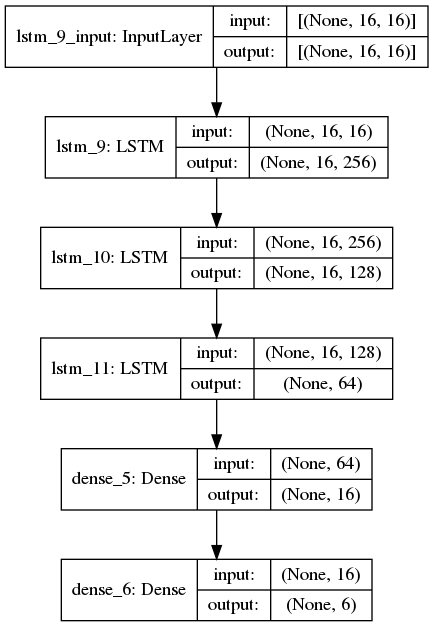

In [47]:
model_classifier = keras.models.Sequential()
model_classifier.add(keras.layers.LSTM( 256,
                                        activation='tanh',
                                        return_sequences = True,
                                        input_shape=(gait_key_poses, full_vec_shape)
                                    )
                        )
model_classifier.add(keras.layers.LSTM( 128,
                                        activation='tanh',
                                        return_sequences=True,
                        )
                    )
model_classifier.add(keras.layers.LSTM(64,
                                       activation='tanh'
                        )
                    )
model_classifier.add(keras.layers.Dense(16,
                                        activation='tanh'
                        )
                    )
model_classifier.add(keras.layers.Dense(len(labels),
                                       activation='softmax'
                        )
                    )
model_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plot_model(model_classifier, to_file='media/model_classifier_plot.png', show_shapes=True, show_layer_names=True)
im = Image.open('media/model_classifier_plot.png')
im

In [11]:
model_classifier.fit(PEI_Vecs, y,epochs=100)

Epoch 1/100
24/24 [==============================] - 4s 13ms/step - loss: 1.8157 - accuracy: 0.1443
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 1.7939 - accuracy: 0.1669
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 1.7821 - accuracy: 0.1984
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 1.7808 - accuracy: 0.2212
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 1.7779 - accuracy: 0.2243
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 1.7693 - accuracy: 0.2338
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 1.7581 - accuracy: 0.2324
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 1.7533 - accuracy: 0.2361
Epoch 9/100
24/24 [==============================] - 0s 13ms/step - loss: 1.7364 - accuracy: 0.2624
Epoch 10/100
24/24 [==============================] - 0s 14ms/step - loss: 1.7351 - accuracy: 0.2785

In [12]:
model_classifier.save('weights/classifier.h5')

In [48]:
model_classifier.load_weights('weights/classifier.h5')

# Adding Occlusions

In [54]:
def occlude(enc_vec, labels, occluRatio=0.3):
    enc_vecs = copy.deepcopy(enc_vec)
    for i, label in enumerate(labels):
        for j in range(len(enc_vecs[i])):
            mask = np.random.random((len(enc_vecs[i][j]),1)) > occluRatio
            enc_vecs[i][j] = mask*enc_vecs[i][j]
    return enc_vecs

In [88]:
def filter_enc(enc_vec, model_birnn, labels):
    batch_enc = []
    for i, label in enumerate(labels):
        for j in range(len(enc_vec[i])):
            for k in range(len(enc_vec[i][j])-6 + 1):
                batch_enc.append(enc_vec[i][j][k:k+6])
    batch_enc = np.array(batch_enc)

    batch_enc = model_birnn.predict( batch_enc )
    cnt = 0

    for i, label in enumerate(labels):
        for j in range(len(enc_vec[i])):
            for k in range(len(enc_vec[i][j])-6 + 1):
                enc_vec[i][j][k:k+6] = batch_enc[cnt]
                cnt+=1
    
    return enc_vec

In [89]:
model_BiRNN.load_weights('weights/BiRNN.h5')

In [133]:
enc_i = occlude(enc_vec, labels, 0.7)

In [134]:
enc_i = filter_enc(enc_i, model_BiRNN, labels)

In [135]:
test_PEI, y = fetch_PEI(enc_i, z, labels)

/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':
/home/hexplex0xff/GAN/gan/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [136]:
y_pred = np.argmax(model_classifier.predict(test_PEI), axis=-1)

In [137]:
accuracy_score(y, y_pred)

0.5883940620782726